In [1]:
import pandas as pd

member = pd.read_csv("Data/정형데이터 프로젝트/Member_data.csv", low_memory=False)
sale   = pd.read_csv("Data/정형데이터 프로젝트/Sales_data.csv",   low_memory=False)

df_merged = pd.merge(sale, member, how='left', on='고객번호').drop(['Unnamed: 0','상품명'], axis=1)
df_merged['구매일'] = pd.to_datetime(df_merged['구매일'])

reference_date = df_merged['구매일'].max()

cust_stats = (
    df_merged
    .groupby('고객번호')
    .agg(
        order_count           = ('고객번호', 'size'),   # 주문 횟수
        last_purchase_date    = ('구매일', 'max')       # 마지막 구매일
    )
    .reset_index()
)

cust_stats['days_since_last_purchase'] = (
    reference_date - cust_stats['last_purchase_date']
).dt.days

child_categories   = {'더블하트','체험팩','기저귀','팬티','SrC'}
hygiene_categories = {'FC','SKC','물티슈','기타','FMC'}
grp = df_merged.groupby('고객번호')

cust_info = pd.DataFrame({
    'categories': grp['물품대분류'].apply(set),
    'max_age':     grp['구매시월령'].max(),
    'marital':     grp['결혼유무'].first(),
    'has_child':   grp['자녀여부'].first(),
})

cust_info = (
    cust_info
    .reset_index()
    .merge(
        cust_stats[['고객번호','order_count','days_since_last_purchase']],
        on='고객번호',
        how='left'
    )
    .set_index('고객번호')
)

def classify_customer(row):
    if pd.isna(row['marital']) and pd.isna(row['has_child']):
        if row['order_count'] == 1:
            return 'guest_order'
        else:
            return 'churned'
    if row['categories'] & child_categories:
        age = row['max_age']
        if age <= 30:
            return 'target'
        elif age <= 142:
            return 'suspected_natural_churn'
        elif age > 142:
            return 'outlier'
        elif row['marital'] =='미혼':
            return 'gift'
    if row['categories'] & hygiene_categories:
        return 'hygiene_only'
    return 'target'
    
cust_info['cust_class'] = cust_info.apply(classify_customer, axis=1)

df_merged = df_merged.merge(
    cust_info[['cust_class','order_count','days_since_last_purchase']],
    on='고객번호',
    how='left'
)
df_merged

,주문번호,배송완료일,배송시작일,구매일,구매시월령,고객번호,구매금액,결제금액,물품대분류,성별,결혼유무,거주지역,연령,결제등록카드,유입경로,자녀여부,cust_class,order_count,days_since_last_purchase
0,901011864201303,2022-01-06,2022-01-02,2022-01-01,35.0,201901010750089,74560,43825,팬티,여,기혼,서울,30.0,롯데카드,인스타그램,Yes,suspected_natural_churn,1,584
1,901011864430366,2022-01-04,2022-01-02,2022-01-01,9.0,201901010750143,74560,43825,팬티,남,기혼,충북,28.0,광주은행,인스타그램,Yes,target,1,584
2,81231186197954,2022-01-06,2022-01-02,2022-01-01,22.0,201812310749820,53920,36769,팬티,여,미혼,서울,31.0,신협중앙회,인스타그램,No,target,5,352
3,812311863500220,2022-01-04,2022-01-02,2022-01-01,8.0,201812310750007,52160,32408,팬티,여,기혼,서울,35.0,신한카드,인스타그램,Yes,target,2,534
4,812311863220192,2022-01-04,2022-01-02,2022-01-01,23.0,201812310749977,47360,30066,팬티,여,기혼,강원,32.0,롯데카드,인스타그램,Yes,target,1,584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199994,00806233401-26770461124511,2023-08-12,2023-08-09,2023-08-08,13.0,201906180918504,21300,14910,FC,여,기혼,인천,36.0,국민카드,인스타그램,Yes,target,15,0
199995,00806204436-0461904922687,2023-08-12,2023-08-09,2023-08-08,163.0,201901280776735,7900,5840,FC,여,기혼,강원,36.0,부산은행,인스타그램,Yes,hygiene_only,2,0
199996,00806204436-0461904922688,2023-08-13,2023-08-09,2023-08-08,163.0,201901280776735,7100,5240,FC,여,기혼,강원,36.0,부산은행,인스타그램,Yes,hygiene_only,2,0
199997,00806215930-05281256126202,2023-08-11,2023-08-09,2023-08-08,5.0,201906200921415,7100,5240,FC,여,기혼,경북,33.0,롯데카드,인스타그램,Yes,hygiene_only,4,0


In [35]:
import pandas as pd

# 전체 날짜 생성
all_dates = pd.date_range(start="2023-01-01", end="2023-08-08", freq="D")

# 실제 구매일 (중복 제거)
actual_dates = pd.to_datetime(df_merged["구매일"].unique())

# 존재하지 않는 날짜 찾기
missing_dates = sorted(set(all_dates) - set(actual_dates))

# 상위 3개 날짜 출력
print("구매일에 존재하지 않는 날짜 (예시 3개):")
print(missing_dates[:3])


구매일에 존재하지 않는 날짜 (예시 3개):
[Timestamp('2023-03-18 00:00:00'), Timestamp('2023-03-19 00:00:00'), Timestamp('2023-03-28 00:00:00')]


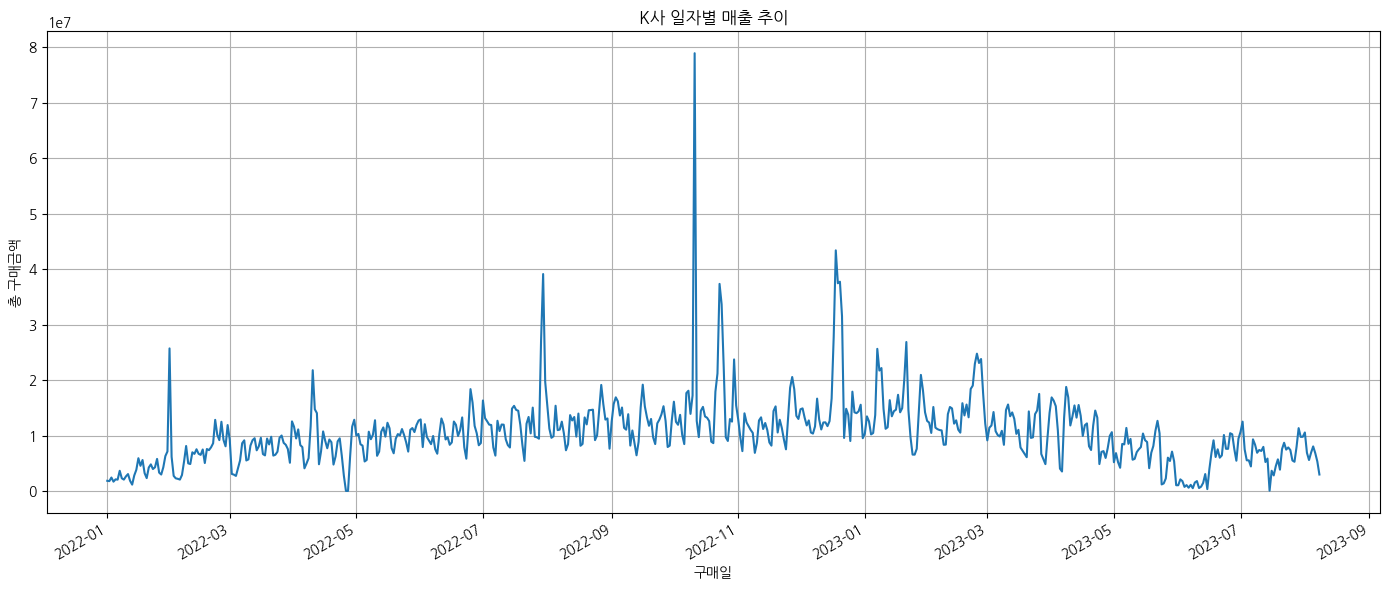

In [4]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import koreanize_matplotlib


# 구매일을 기준으로 일별 매출 집계
daily_sales = df_merged.groupby("구매일")["구매금액"].sum()

# 그래프 시각화
plt.figure(figsize=(14, 6))
daily_sales.plot()
plt.title("K사 일자별 매출 추이")
plt.xlabel("구매일")
plt.ylabel("총 구매금액")
plt.grid(True)
plt.tight_layout()
plt.show()

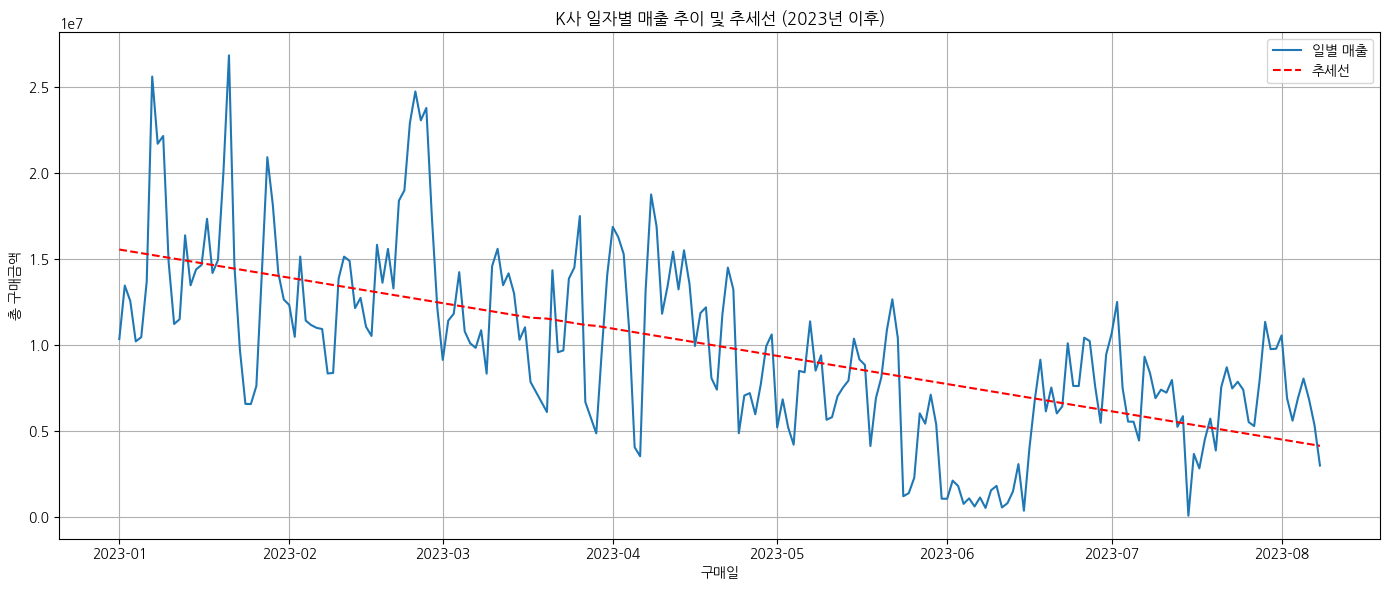

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import koreanize_matplotlib
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# 날짜 필터링
df_filtered = df_merged[df_merged["구매일"] >= pd.to_datetime("2023-01-01")]

# 일자별 매출 집계
daily_sales = df_filtered.groupby("구매일")["구매금액"].sum()

# x축: 날짜를 숫자형으로 변환 (matplotlib 선형회귀용)
x = np.arange(len(daily_sales))
y = daily_sales.values

# 선형 회귀 추세선 계산
coeffs = np.polyfit(x, y, deg=1)  # 1차 방정식 (선형)
trend = np.poly1d(coeffs)

# 시각화
plt.figure(figsize=(14, 6))
plt.plot(daily_sales.index, y, label="일별 매출")
plt.plot(daily_sales.index, trend(x), label="추세선", color="red", linestyle="--")
plt.title("K사 일자별 매출 추이 및 추세선 (2023년 이후)")
plt.xlabel("구매일")
plt.ylabel("총 구매금액")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [37]:
coeffs, trend

(array([  -52915.01761581, 15547967.47854394]),
 poly1d([  -52915.01761581, 15547967.47854394]))

In [34]:
import pandas as pd

# 날짜 생성
purchase_days = pd.date_range(start="2023-01-01", end="2023-08-08", freq="D")
purchase_days_list = purchase_days.strftime("%Y-%m-%d").tolist()

# 출력
for date in purchase_days_list:
    print(date)

2023-01-01
2023-01-02
2023-01-03
2023-01-04
2023-01-05
2023-01-06
2023-01-07
2023-01-08
2023-01-09
2023-01-10
2023-01-11
2023-01-12
2023-01-13
2023-01-14
2023-01-15
2023-01-16
2023-01-17
2023-01-18
2023-01-19
2023-01-20
2023-01-21
2023-01-22
2023-01-23
2023-01-24
2023-01-25
2023-01-26
2023-01-27
2023-01-28
2023-01-29
2023-01-30
2023-01-31
2023-02-01
2023-02-02
2023-02-03
2023-02-04
2023-02-05
2023-02-06
2023-02-07
2023-02-08
2023-02-09
2023-02-10
2023-02-11
2023-02-12
2023-02-13
2023-02-14
2023-02-15
2023-02-16
2023-02-17
2023-02-18
2023-02-19
2023-02-20
2023-02-21
2023-02-22
2023-02-23
2023-02-24
2023-02-25
2023-02-26
2023-02-27
2023-02-28
2023-03-01
2023-03-02
2023-03-03
2023-03-04
2023-03-05
2023-03-06
2023-03-07
2023-03-08
2023-03-09
2023-03-10
2023-03-11
2023-03-12
2023-03-13
2023-03-14
2023-03-15
2023-03-16
2023-03-17
2023-03-18
2023-03-19
2023-03-20
2023-03-21
2023-03-22
2023-03-23
2023-03-24
2023-03-25
2023-03-26
2023-03-27
2023-03-28
2023-03-29
2023-03-30
2023-03-31
2023-04-01

In [31]:
pd.DataFrame(daily_sales)

,구매금액
구매일,
2023-01-01,10335160
2023-01-02,13450950
2023-01-03,12552340
2023-01-04,10199870
2023-01-05,10442020
...,...
2023-08-04,6911090
2023-08-05,8034210
2023-08-06,6836140


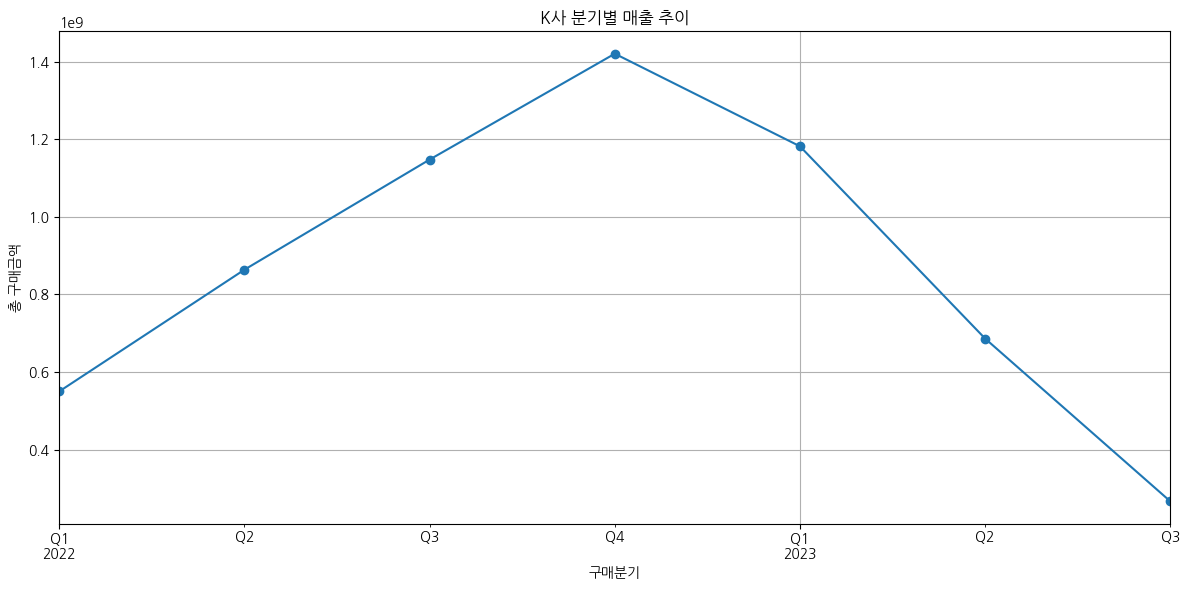

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

# 구매분기 컬럼 생성 (ex: 2021Q1)
df_merged["구매분기"] = df_merged["구매일"].dt.to_period("Q").dt.to_timestamp()

# 분기별 매출 합계 집계
quarterly_sales = df_merged.groupby("구매분기")["구매금액"].sum()

# 그래프 시각화
plt.figure(figsize=(12, 6))
quarterly_sales.plot(kind="line", marker="o")
plt.title("K사 분기별 매출 추이")
plt.xlabel("구매분기")
plt.ylabel("총 구매금액")
plt.grid(True)
plt.tight_layout()
plt.show()

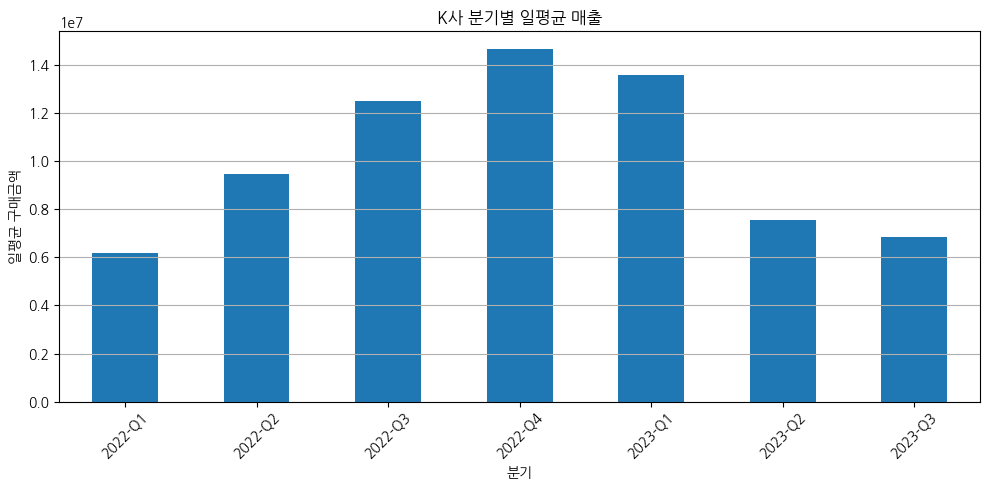

In [13]:
# 분기별 기간 정의 함수
def define_quarter(date):
    if date.month <= 3:
        return f"{date.year}-Q1"
    elif date.month <= 6:
        return f"{date.year}-Q2"
    elif date.month <= 8:
        return f"{date.year}-Q3"
    else:
        return f"{date.year}-Q4"

# 분기 레이블 생성
df_merged["수동분기"] = df_merged["구매일"].apply(define_quarter)

# 분기별 매출 합계 + 일수 계산
sales_by_quarter = df_merged.groupby("수동분기").agg(
    total_sales=("구매금액", "sum"),
    unique_days=("구매일", lambda x: x.nunique())
)

# 일평균 매출 계산
sales_by_quarter["일평균매출"] = sales_by_quarter["total_sales"] / sales_by_quarter["unique_days"]

# 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sales_by_quarter["일평균매출"].plot(kind="bar")
plt.title("K사 분기별 일평균 매출")
plt.ylabel("일평균 구매금액")
plt.xlabel("분기")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

고객군 분포 (cust_class별 인원 수)

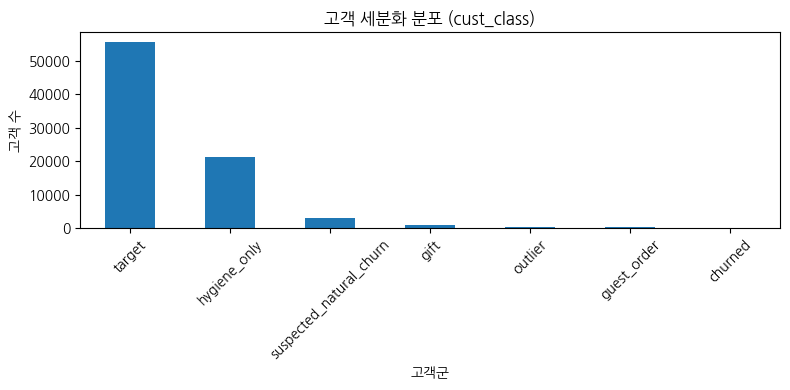

In [4]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import koreanize_matplotlib

cust_info['cust_class'].value_counts().plot(kind='bar', figsize=(8, 4))
plt.title('고객 세분화 분포 (cust_class)')
plt.xlabel('고객군')
plt.ylabel('고객 수')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

 고객군별 평균 구매 횟수

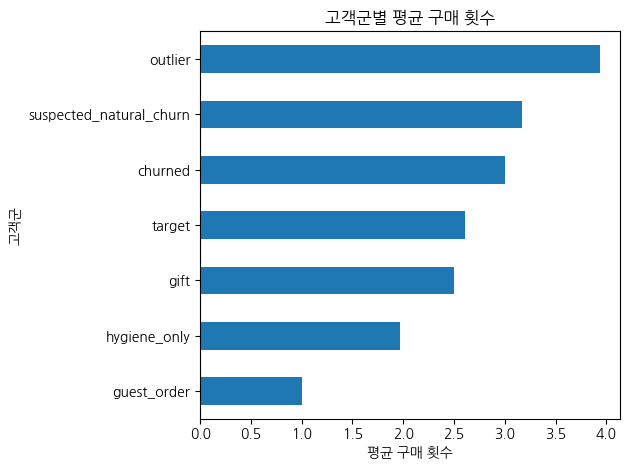

In [5]:
cust_info.groupby('cust_class')['order_count'].mean().sort_values().plot(kind='barh')
plt.title('고객군별 평균 구매 횟수')
plt.xlabel('평균 구매 횟수')
plt.ylabel('고객군')
plt.tight_layout()
plt.show()

고객군별 최근 구매 시점 분포 (이탈 추정)

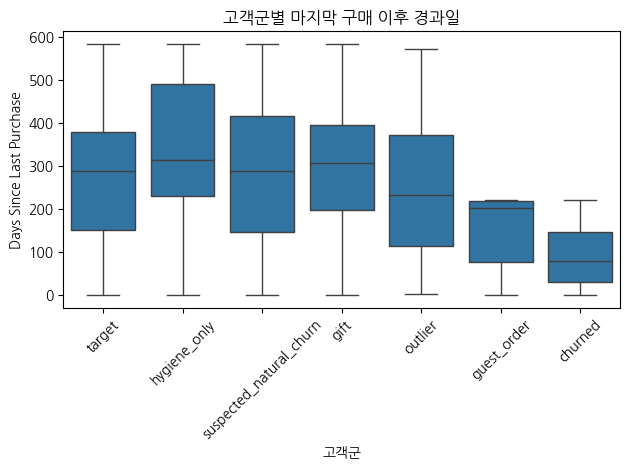

In [6]:
import seaborn as sns

sns.boxplot(x='cust_class', y='days_since_last_purchase', data=cust_info.reset_index())
plt.title('고객군별 마지막 구매 이후 경과일')
plt.xlabel('고객군')
plt.ylabel('Days Since Last Purchase')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

주요 고객군별 구매 상품 카테고리 비중

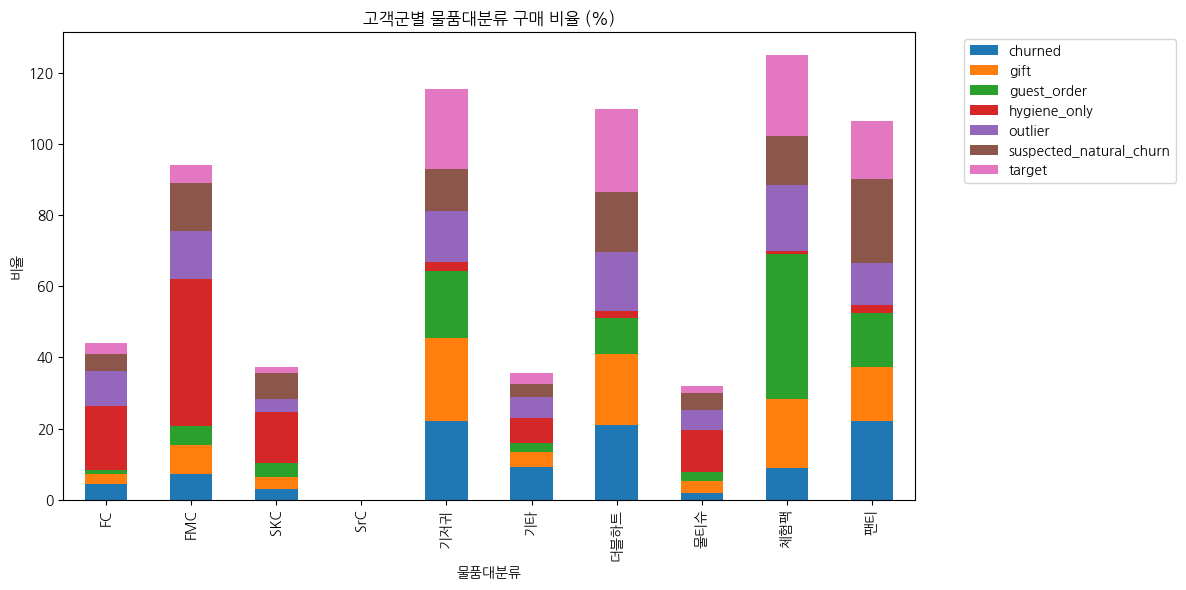

In [7]:
import pandas as pd

cross_tab = pd.crosstab(df_merged['cust_class'], df_merged['물품대분류'], normalize='index') * 100
cross_tab.T.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('고객군별 물품대분류 구매 비율 (%)')
plt.ylabel('비율')
plt.xlabel('물품대분류')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

월령 분포 비교 (target vs suspected_natural_churn 등)

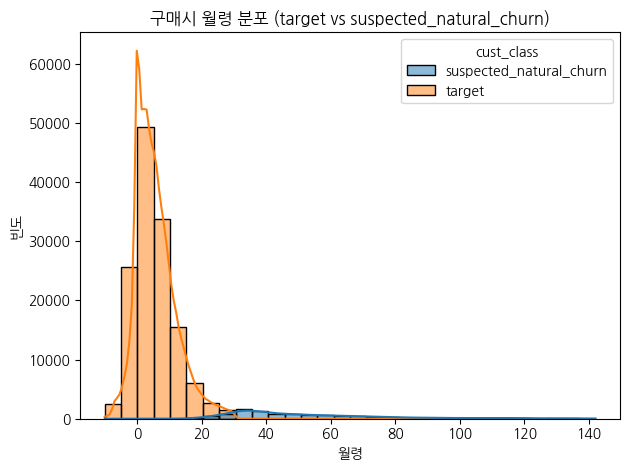

In [21]:
sns.histplot(data=df_merged[df_merged['cust_class'].isin(['target', 'suspected_natural_churn'])],
             x='구매시월령', hue='cust_class', bins=30, kde=True)
plt.title('구매시 월령 분포 (target vs suspected_natural_churn)')
plt.xlabel('월령')
plt.ylabel('빈도')
plt.tight_layout()
plt.show()

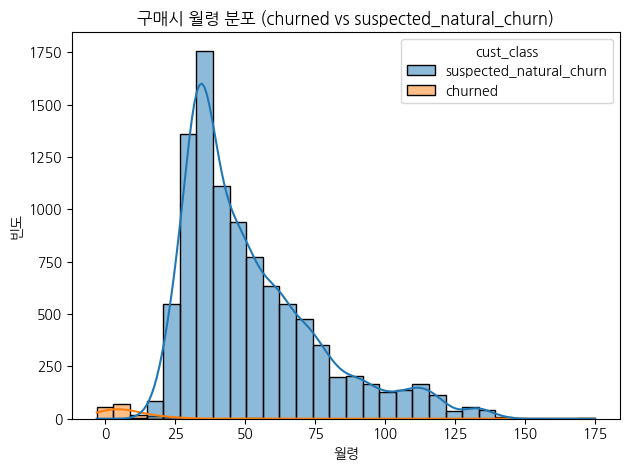

In [22]:
sns.histplot(data=df_merged[df_merged['cust_class'].isin(['churned', 'suspected_natural_churn'])],
             x='구매시월령', hue='cust_class', bins=30, kde=True)
plt.title('구매시 월령 분포 (churned vs suspected_natural_churn)')
plt.xlabel('월령')
plt.ylabel('빈도')
plt.tight_layout()
plt.show()

# 실제이탈고객과 비교했을떄 실제고객이 비슷한 월령분포를 보이진않음 

고객군별 구매 생애주기 (Lifecycle) 분석

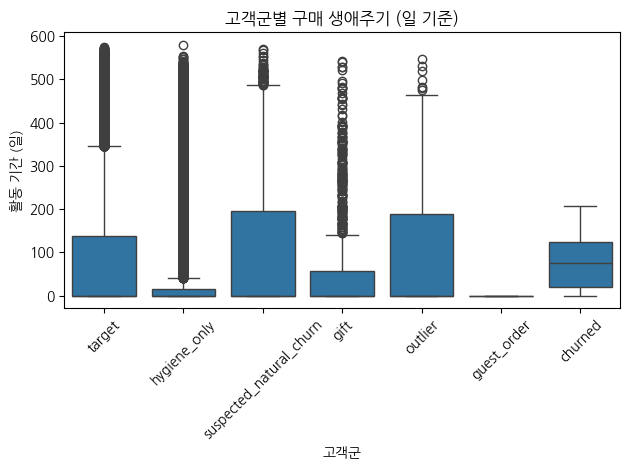

In [9]:
df_life = df_merged.groupby('고객번호').agg(
    first_purchase=('구매일', 'min'),
    last_purchase =('구매일', 'max')
)
df_life['purchase_span'] = (df_life['last_purchase'] - df_life['first_purchase']).dt.days

df_life = df_life.merge(cust_info[['cust_class']], left_index=True, right_index=True)

sns.boxplot(x='cust_class', y='purchase_span', data=df_life)
plt.title('고객군별 구매 생애주기 (일 기준)')
plt.xlabel('고객군')
plt.ylabel('활동 기간 (일)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

고객군별 재구매 간격 분석

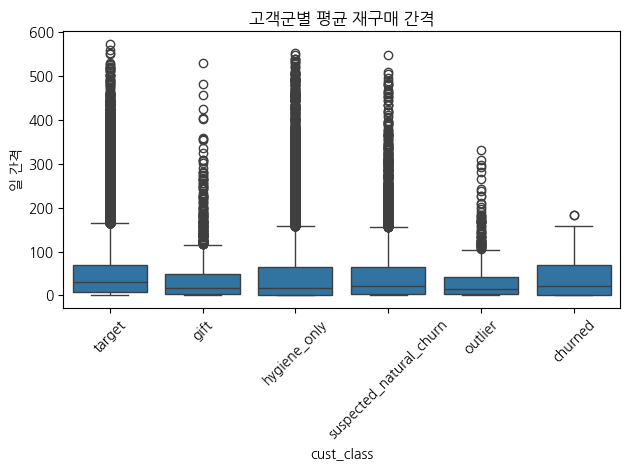

In [23]:
def compute_repurchase_intervals(df):
    df = df.sort_values('구매일')
    return df['구매일'].diff().dt.days.dropna()

repurchase_intervals = df_merged.groupby('고객번호').apply(compute_repurchase_intervals).reset_index()
repurchase_intervals.columns = ['고객번호', 'idx', 'repurchase_gap']

repurchase_intervals = repurchase_intervals.merge(
    cust_info[['cust_class']], on='고객번호', how='left'
)

sns.boxplot(x='cust_class', y='repurchase_gap', data=repurchase_intervals)
plt.title('고객군별 평균 재구매 간격')
plt.ylabel('일 간격')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

고객군별 결제 수단 분석

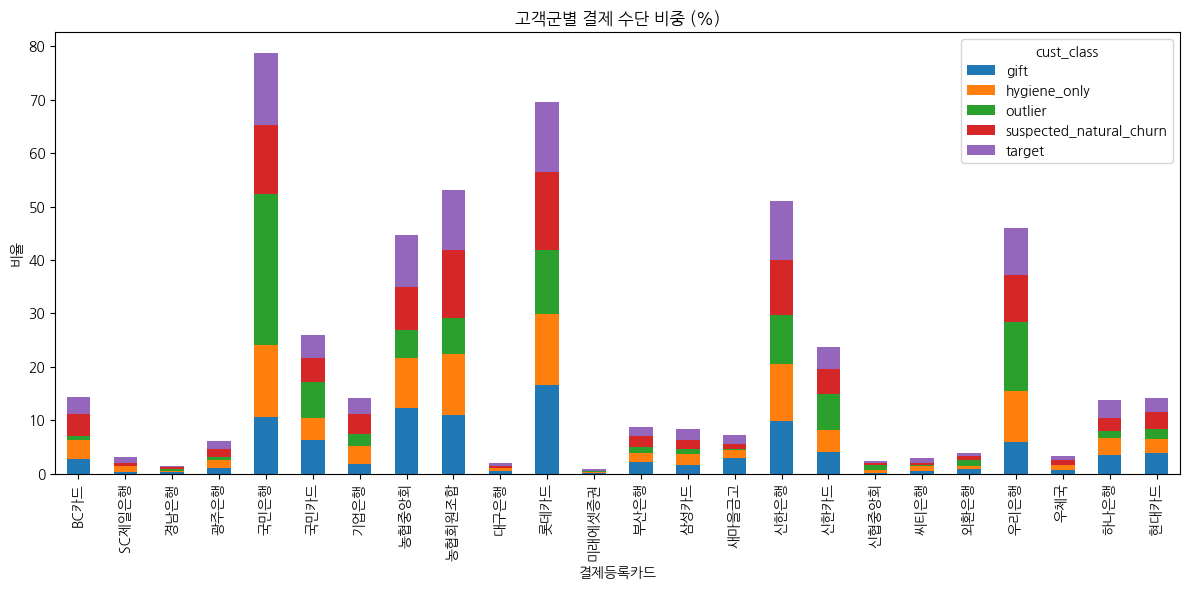

In [16]:
pay_dist = pd.crosstab(df_merged['cust_class'], df_merged['결제등록카드'], normalize='index') * 100
pay_dist.T.sort_index().plot(kind='bar', stacked=True, figsize=(12,6))
plt.title('고객군별 결제 수단 비중 (%)')
plt.ylabel('비율')
plt.tight_layout()
plt.show()

 고객군별 지역 클러스터링 분석

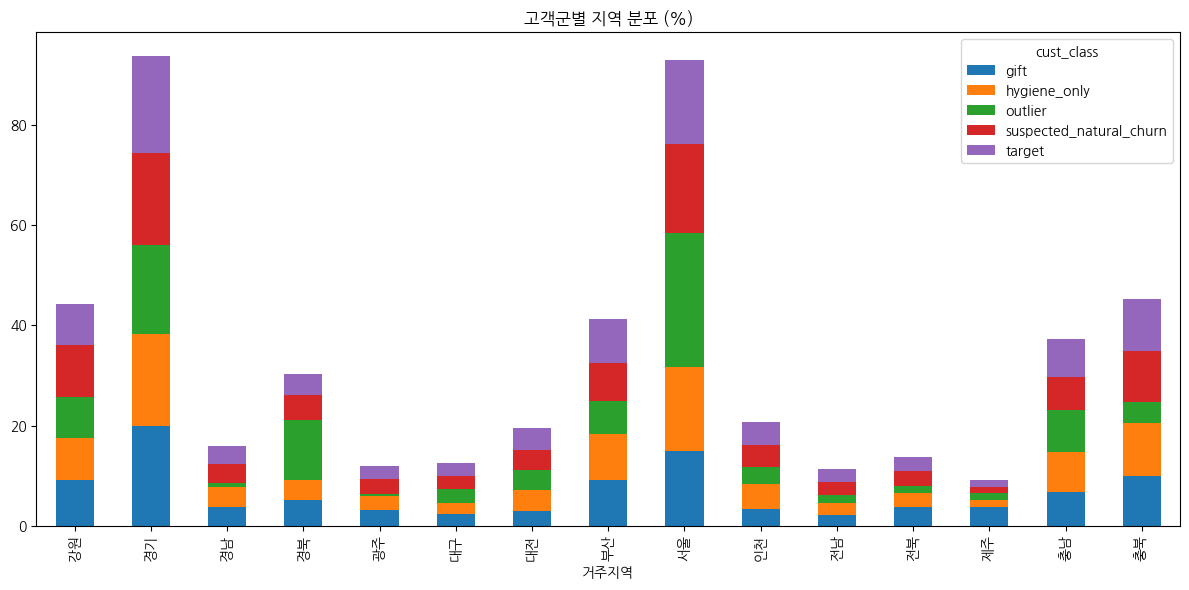

In [17]:
region_dist = pd.crosstab(df_merged['cust_class'], df_merged['거주지역'], normalize='index') * 100
region_dist.T.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('고객군별 지역 분포 (%)')
plt.tight_layout()
plt.show()

구매 월령별 고객군 분포 밀도

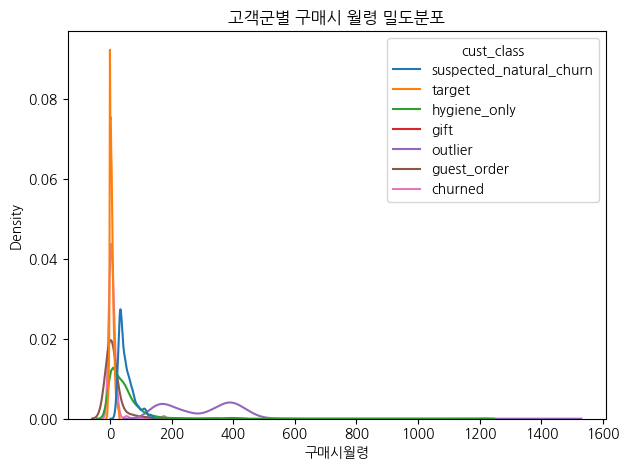

In [18]:
sns.kdeplot(data=df_merged, x='구매시월령', hue='cust_class', common_norm=False)
plt.title('고객군별 구매시 월령 밀도분포')
plt.tight_layout()
plt.show()

이탈 의심 고객군의 최근 소비 품목

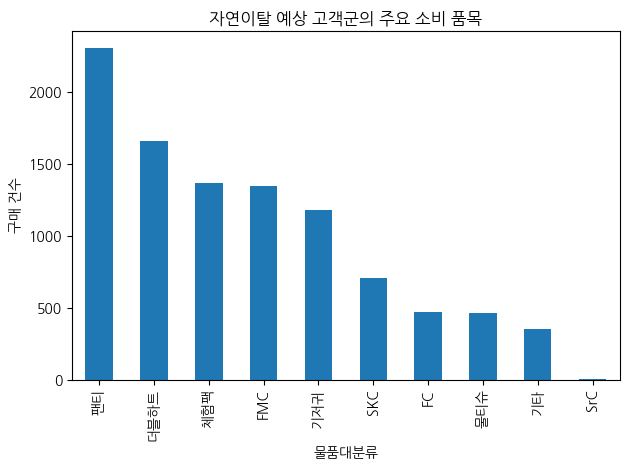

In [32]:
df_churn = df_merged[df_merged['cust_class'] == 'suspected_natural_churn']
top_items = df_churn['물품대분류'].value_counts().head(10)

top_items.plot(kind='bar', title='자연이탈 예상 고객군의 주요 소비 품목')
plt.ylabel('구매 건수')
plt.tight_layout()
plt.show()

 'suspected_natural_churn' → 재활성화 가능성 예측

In [33]:
# 최근 소비일이 기준일 기준 30일 이내이면 재활성화 가능성 있음
cust_info['reactivation_candidate'] = (
    (cust_info['cust_class'] == 'suspected_natural_churn') &
    (cust_info['days_since_last_purchase'] <= 30)
)
cust_info['reactivation_candidate'].value_counts()

reactivation_candidate
False    81113
True       247
Name: count, dtype: int64

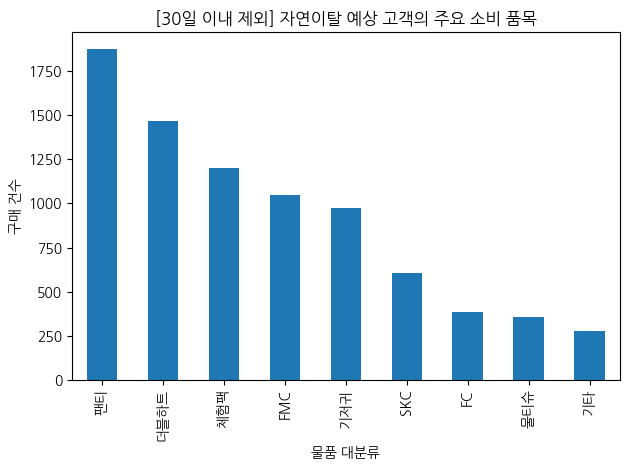

In [35]:
# 1. 재활성화 가능성이 있는 suspected_natural_churn 고객 ID
reactivatable_ids = cust_info[
    (cust_info['cust_class'] == 'suspected_natural_churn') &
    (cust_info['days_since_last_purchase'] <= 30)
].index

# 2. 재활성화 가능성 없는 고객만 필터링
df_churn_filtered = df_merged[
    (df_merged['cust_class'] == 'suspected_natural_churn') &
    (~df_merged['고객번호'].isin(reactivatable_ids))
]

# 3. 이 고객들의 주요 소비 품목 확인
top_items_filtered = df_churn_filtered['물품대분류'].value_counts().head(10)

# 4. 시각화
import matplotlib.pyplot as plt

top_items_filtered.plot(kind='bar', title='[30일 이내 제외] 자연이탈 예상 고객의 주요 소비 품목')
plt.ylabel('구매 건수')
plt.xlabel('물품 대분류')
plt.tight_layout()
plt.show()
